# **Final Project**

##**Problem stament :**     

The widespread dissemination of fake news and propaganda presents serious societal risks, including the erosion of public trust, political polarization, manipulation of elections, and the spread of harmful misinformation during crises such as pandemics or conflicts. From an NLP perspective, detecting fake news is fraught with challenges. Linguistically, fake news often mimics the tone and structure of legitimate journalism, making it difficult to distinguish using surface-level features. The absence of reliable and up-to-date labeled datasets, especially across multiple languages and regions, hampers the effectiveness of supervised learning models. Additionally, the dynamic and adversarial nature of misinformation means that malicious actors constantly evolve their language and strategies to bypass detection systems. Cultural context, sarcasm, satire, and implicit bias further complicate automated analysis. Moreover, NLP models risk amplifying biases present in training data, leading to unfair classifications and potential censorship of legitimate content. These challenges underscore the need for cautious, context-aware approaches, as the failure to address them can inadvertently contribute to misinformation, rather than mitigate it.



Use datasets in link : https://drive.google.com/drive/folders/1mrX3vPKhEzxG96OCPpCeh9F8m_QKCM4z?usp=sharing
to complete requirement.

## **About dataset:**

* **True Articles**:

  * **File**: `MisinfoSuperset_TRUE.csv`
  * **Sources**:

    * Reputable media outlets like **Reuters**, **The New York Times**, **The Washington Post**, etc.

* **Fake/Misinformation/Propaganda Articles**:

  * **File**: `MisinfoSuperset_FAKE.csv`
  * **Sources**:

    * **American right-wing extremist websites** (e.g., Redflag Newsdesk, Breitbart, Truth Broadcast Network)
    * **Public dataset** from:

      * Ahmed, H., Traore, I., & Saad, S. (2017): "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques" *(Springer LNCS 10618)*



## **Requirement**

A team consisting of three members must complete a project that involves applying the methods learned from the beginning of the course up to the present. The team is expected to follow and document the entire machine learning workflow, which includes the following steps:

1. **Data Preprocessing**: Clean and prepare the dataset,etc.

2. **Exploratory Data Analysis (EDA)**: Explore and visualize the data.

3. **Model Building**: Select and build one or more machine learning models suitable for the problem at hand.

4. **Hyperparameter set up**: Set and adjust the model's hyperparameters using appropriate methods to improve performance.

5. **Model Training**: Train the model(s) on the training dataset.

6. **Performance Evaluation**: Evaluate the trained model(s) using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix, etc.) and validate their performance on unseen data.

7. **Conclusion**: Summarize the results, discuss the model's strengths and weaknesses, and suggest possible improvements or future work.





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned")

In [4]:
df.head()

,text,label,text_length
0,link imo happening guys jumping conclusions co...,1,2717
1,house passed budget today slim margin democrat...,1,3203
2,youtube video posted january cloudgate studio ...,0,2549
3,marseille france sang danced chanted even reas...,0,8149
4,sunday nbc meet press discussing president don...,0,1235


In [1]:
!pip uninstall keras -y
!pip uninstall opencv-python -y
!pip uninstall numpy -y
!pip install keras
!pip install opencv-python
!pip install numpy

Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: numpy 2.3.0
Uninstalling numpy-2.3.0:
  Successfully uninstalled numpy-2.3.0
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl (16.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0 which is incompatible.
cupy-cuda12x 13.3.0 requi

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [5]:
# -------------------------
# IMPORTS
# -------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# -------------------------
# HYPERPARAMETER CONFIGURATION
# -------------------------
# GloVe parameters
min_count = 5 #Lọc ra các từ hiếm, chỉ giữ lại từ xuất hiện ≥5 lần giúp giảm nhiễu và giảm số chiều từ điển.
window_size = 5 #	Kích thước ngữ cảnh (context window). Gía trị 5 là chuẩn trong GloVe, cân bằng giữa từ gần và xa.
embed_dim = 100 #Kích thước vector từ vựng. 100 là một giá trị phổ biến, đủ để giữ ngữ nghĩa nhưng vẫn nhanh khi training.
x_max = 100 #Tham số giới hạn cho hàm trọng số (weighting function
alpha = 0.75 #Power scaling trong hàm weighting
batch_size = 512 #Kích thước batch vừa phải, tối ưu cho GPU training mà không bị thiếu bộ nhớ.
lr = 0.001 #LR phổ biến cho Adam optimizer, giúp mô hình học ổn định.
epochs = 3 #Số vòng lặp nhỏ vì GloVe

# Classifier parameters
hidden_dim = 128 #Số chiều của hidden state trong RNN. 128 là kích thước chuẩn để giữ được ngữ cảnh.
batch_size = 64
max_len = 200 #Cắt văn bản về độ dài tối đa 200 từ. Giúp xử lý tài nguyên hiệu quả, tránh padding quá nhiều.
lr = 0.001
epochs = 5

# Split ratios
val_ratio = 0.25
test_ratio = 0.2
random_state = 42

# -------------------------
# GLOVE DATASET
# -------------------------
class GloVeDataset:
    def __init__(self, corpus, min_count=5, window_size=5):
        self.window_size = window_size
        self.min_count = min_count

        tokens = corpus.split()
        word_counts = Counter(tokens)
        word_counts = Counter({w: c for w, c in word_counts.items() if c >= min_count})

        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.word2idx.update({w: i+2 for i, (w, _) in enumerate(word_counts.most_common())})
        self.idx2word = {i: w for w, i in self.word2idx.items()}

        self.token_ids = [self.word2idx.get(w, 1) for w in tokens]
        self.create_cooccurrence_matrix()

    def create_cooccurrence_matrix(self):
        cooc = defaultdict(Counter)
        for i, center in enumerate(self.token_ids):
            left = max(i - self.window_size, 0)
            right = min(i + self.window_size + 1, len(self.token_ids))
            for j in range(left, right):
                if i == j: continue
                context = self.token_ids[j]
                cooc[center][context] += 1 / abs(i - j)

        self.in_ids, self.out_ids, self.counts = [], [], []
        for center_id, contexts in cooc.items():
            for context_id, count in contexts.items():
                self.in_ids.append(center_id)
                self.out_ids.append(context_id)
                self.counts.append(count)

        self.in_ids = torch.tensor(self.in_ids, dtype=torch.long)
        self.out_ids = torch.tensor(self.out_ids, dtype=torch.long)
        self.counts = torch.tensor(self.counts, dtype=torch.float)

    def get_batches(self, batch_size):
        indices = torch.randperm(len(self.in_ids))
        for i in range(0, len(indices), batch_size):
            idx = indices[i:i+batch_size]
            yield self.in_ids[idx], self.out_ids[idx], self.counts[idx]

# -------------------------
# GLOVE MODEL
# -------------------------
class GloVeModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, x_max=100, alpha=0.75):
        super().__init__()
        self.embed_dim = embed_dim
        self.x_max = x_max
        self.alpha = alpha

        self.input_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.input_bias = nn.Embedding(vocab_size, 1)
        self.output_bias = nn.Embedding(vocab_size, 1)

        nn.init.xavier_uniform_(self.input_embeddings.weight)
        nn.init.xavier_uniform_(self.output_embeddings.weight)
        self.input_bias.weight.data.zero_()
        self.output_bias.weight.data.zero_()

    def forward(self, input_ids, output_ids, co_counts):
        input_emb = self.input_embeddings(input_ids)
        output_emb = self.output_embeddings(output_ids)
        input_b = self.input_bias(input_ids).squeeze()
        output_b = self.output_bias(output_ids).squeeze()

        dot = (input_emb * output_emb).sum(dim=1)
        log_co = torch.log(co_counts + 1)
        weights = torch.pow(torch.clamp(co_counts / self.x_max, max=1.0), self.alpha)

        loss = weights * (dot + input_b + output_b - log_co) ** 2
        return loss.mean()

# -------------------------
# CLASSIFIER
# -------------------------
class NewsDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len=200):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx].split()
        token_ids = [self.word2idx.get(t, 1) for t in tokens][:self.max_len]
        return torch.tensor(token_ids), torch.tensor(self.labels[idx], dtype=torch.float)

def collate_fn(batch):
    token_ids, labels = zip(*batch)
    padded = pad_sequence(token_ids, batch_first=True, padding_value=0)
    return padded, torch.tensor(labels)

# -------------------------
# PIPELINE: DATA > GLOVE > RNN/Deep BiLSTM > EVALUATION
# -------------------------

# 1. Load cleaned data
df['text'] = df['text'].astype(str).str.lower()

# 2. Train GloVe
corpus = ' '.join(df['text'].tolist())
glove_data = GloVeDataset(corpus, min_count=5, window_size=5)
vocab_size = len(glove_data.word2idx)
glove_model = GloVeModel(vocab_size, embed_dim=100).to(device)
glove_optim = optim.Adam(glove_model.parameters(), lr=0.001)

for epoch in range(3):
    glove_model.train()
    total_loss = 0
    for in_ids, out_ids, counts in glove_data.get_batches(512):
        in_ids, out_ids, counts = in_ids.to(device), out_ids.to(device), counts.to(device)
        glove_optim.zero_grad()
        loss = glove_model(in_ids, out_ids, counts)
        loss.backward()
        glove_optim.step()
        total_loss += loss.item()
    print(f"[GloVe] Epoch {epoch+1}, Loss: {total_loss:.4f}")

# 3. Prepare embedding matrix
embedding_matrix = (glove_model.input_embeddings.weight.data + glove_model.output_embeddings.weight.data) / 2

# 4. Split dataset
X_temp, X_test, y_temp, y_test = train_test_split(df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

train_ds = NewsDataset(X_train, y_train, glove_data.word2idx)
val_ds = NewsDataset(X_val, y_val, glove_data.word2idx)
test_ds = NewsDataset(X_test, y_test, glove_data.word2idx)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

[GloVe] Epoch 1, Loss: 3618.2244
[GloVe] Epoch 2, Loss: 2465.6675
[GloVe] Epoch 3, Loss: 2311.8789


#RNN

In [6]:
class FakeNewsRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(
            embedding_matrix.size(1),
            hidden_dim,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid() #Đưa output về [0, 1] để dễ threshold phân lớp (0.5).


    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        h_cat = h_n.squeeze(0)
        return self.sigmoid(self.fc(h_cat)).squeeze()


In [7]:
# 5. Train RNN
model_rnn = FakeNewsRNN(embedding_matrix).to(device)
criterion = nn.BCELoss() #Do đây là bài toán phân loại nhị phân (giả - thật), nên dùng Binary Cross Entropy.
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-3)

for epoch in range(5):
    model_rnn.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_rnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[RNN] Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")


# 6. Evaluate
model_rnn.eval()
preds, targets = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_rnn(inputs)
        pred = (outputs > 0.5).cpu().numpy()
        preds.extend(pred)
        targets.extend(labels.numpy())

print("Validation Accuracy:", accuracy_score(targets, preds))
print("Validation Precision:", precision_score(targets, preds))
print("Validation Recall:", recall_score(targets, preds))
print("Validation F1:", f1_score(targets, preds))

[RNN] Epoch 1, Train Loss: 0.6224
[RNN] Epoch 2, Train Loss: 0.5636
[RNN] Epoch 3, Train Loss: 0.4458
[RNN] Epoch 4, Train Loss: 0.3910
[RNN] Epoch 5, Train Loss: 0.4342
Validation Accuracy: 0.5013482982289921
Validation Precision: 0.5
Validation Recall: 0.5093539900613856
Validation F1: 0.5046336518969012


In [8]:
model_rnn.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_rnn(inputs)
        pred = (outputs > 0.5).cpu().numpy()
        test_preds.extend(pred)
        test_targets.extend(labels.numpy())

print("Test Accuracy:", accuracy_score(test_targets, test_preds))
print("Test Precision:", precision_score(test_targets, test_preds))
print("Test Recall:", recall_score(test_targets, test_preds))
print("Test F1:", f1_score(test_targets, test_preds))


Test Accuracy: 0.5043364186283799
Test Precision: 0.5005098324836126
Test Recall: 0.5047003525264395
Test F1: 0.5025963577854166


#Deep BiLSTM

In [9]:
class FakeNewsDeepBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(
            input_size=embedding_matrix.size(1),
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 vì BiLSTM
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len, embed_dim]
        output, (h_n, c_n) = self.lstm(x)

        # lấy hidden state từ layer cuối cùng (vì nhiều tầng, h_n shape = [num_layers * 2, batch, hidden_dim])
        h_forward = h_n[-2, :, :]  # forward của tầng cuối
        h_backward = h_n[-1, :, :] # backward của tầng cuối

        h_cat = torch.cat((h_forward, h_backward), dim=1)  # [batch, hidden_dim * 2]
        return self.sigmoid(self.fc(h_cat)).squeeze()


In [10]:
# 5. Train LSTM
model_bilstm = FakeNewsDeepBiLSTM(embedding_matrix, hidden_dim=128, num_layers=2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_bilstm.parameters(), lr=1e-3)

for epoch in range(5):
    model_bilstm.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_bilstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[BiLSTM] Epoch {epoch+1}, Train Loss: {total_loss:.4f}")


# 6. Evaluate
model_bilstm.eval()
preds, targets = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_bilstm(inputs)
        pred = (outputs > 0.5).cpu().numpy()
        preds.extend(pred)
        targets.extend(labels.numpy())

print("Validation Accuracy:", accuracy_score(targets, preds))
print("Validation Precision:", precision_score(targets, preds))
print("Validation Recall:", recall_score(targets, preds))
print("Validation F1:", f1_score(targets, preds))


[BiLSTM] Epoch 1, Train Loss: 140.7210
[BiLSTM] Epoch 2, Train Loss: 64.2965
[BiLSTM] Epoch 3, Train Loss: 30.6820
[BiLSTM] Epoch 4, Train Loss: 11.8057
[BiLSTM] Epoch 5, Train Loss: 4.9101
Validation Accuracy: 0.8930835944901975
Validation Precision: 0.9010595433517385
Validation Recall: 0.8824904998538439
Validation F1: 0.8916783578232297


In [11]:
model_bilstm.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_bilstm(inputs)
        pred = (outputs > 0.5).cpu().numpy()
        test_preds.extend(pred)
        test_targets.extend(labels.numpy())

print("Test Accuracy:", accuracy_score(test_targets, test_preds))
print("Test Precision:", precision_score(test_targets, test_preds))
print("Test Recall:", recall_score(test_targets, test_preds))
print("Test F1:", f1_score(test_targets, test_preds))


Test Accuracy: 0.8956344289774798
Test Precision: 0.9013138250223948
Test Recall: 0.8867508813160987
Test F1: 0.8939730490152524


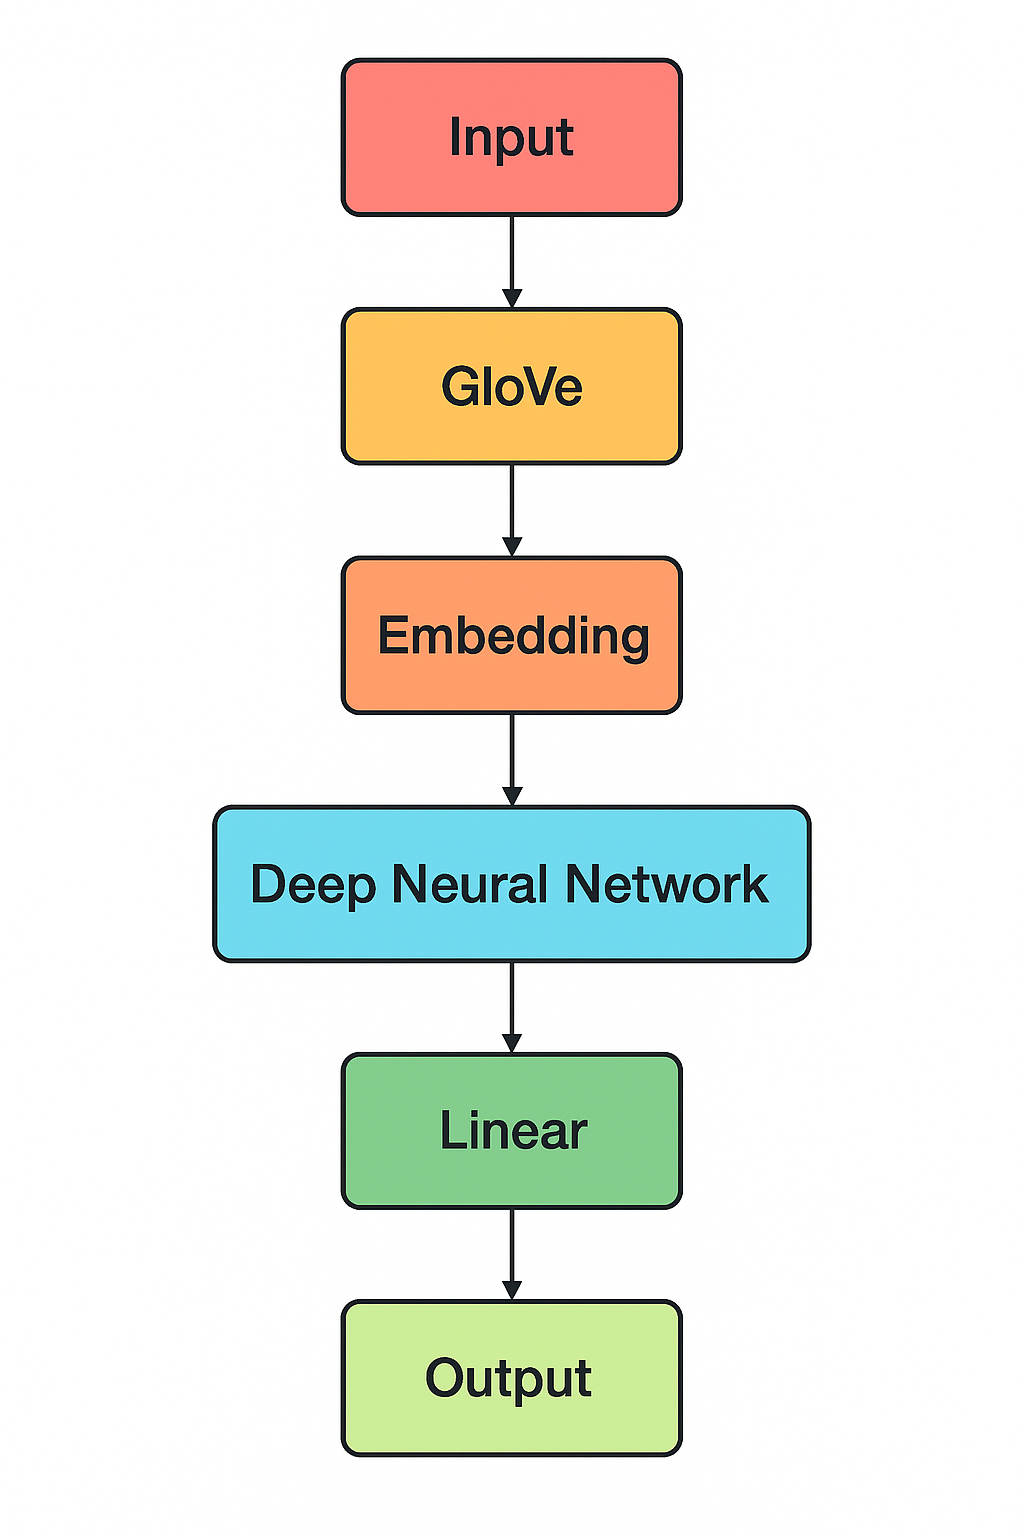